# Understanding PlaNet (Deep Planning Network): A Complete Guide

# Table of Contents

- [Introduction: Model-Based RL with Latent Dynamics](#introduction)
- [What is PlaNet?](#what-is-planet)
  - [Core Idea: Learning Dynamics & Planning in Latent Space](#core-idea)
- [Why PlaNet? The Power of Learned Models & Planning](#why-planet)
- [Where and How PlaNet is Used](#where-and-how-planet-is-used)
- [Mathematical Foundation of PlaNet](#mathematical-foundation-of-planet)
  - [Latent Dynamics Model (Conceptual)](#latent-dynamics-model-conceptual)
    - [Transition Model](#transition-model)
    - [Reward Model](#reward-model)
    - [Observation/Representation Model (Simplified)](#observationrepresentation-model-simplified)
  - [Model Training Objective](#model-training-objective)
  - [Planning with the Model: Cross-Entropy Method (CEM)](#planning-with-the-model-cross-entropy-method-cem)
  - [Action Selection](#action-selection)
- [Step-by-Step Explanation of PlaNet](#step-by-step-explanation-of-planet)
- [Key Components of PlaNet](#key-components-of-planet)
  - [World Model (Dynamics Model)](#world-model-dynamics-model)
  - [Replay Buffer (Sequence-Based)](#replay-buffer-sequence-based)
  - [Model Training Procedure](#model-training-procedure)
  - [Planner (CEM)](#planner-cem)
  - [Action Execution](#action-execution)
  - [Hyperparameters](#hyperparameters)
- [Practical Example: Pendulum Environment](#practical-example-pendulum-environment)
  - [Why Pendulum for this PlaNet Example?](#why-pendulum-for-this-planet-example)
- [Setting up the Environment](#setting-up-the-environment)
- [Creating the Continuous Environment (Gymnasium)](#creating-the-continuous-environment-gymnasium)
- [Implementing the PlaNet Algorithm](#implementing-the-planet-algorithm)
  - [Defining the Dynamics Model (Simplified)](#defining-the-dynamics-model-simplified)
  - [Defining the Sequence Replay Buffer](#defining-the-sequence-replay-buffer)
  - [Implementing the CEM Planner](#implementing-the-cem-planner)
  - [Model Training Function](#model-training-function)
- [Running the PlaNet Algorithm](#running-the-planet-algorithm)
  - [Hyperparameter Setup](#hyperparameter-setup)
  - [Initialization](#initialization)
  - [Training Loop](#training-loop)
- [Visualizing the Learning Process](#visualizing-the-learning-process)
- [Analyzing the Learned Policy (Testing)](#analyzing-the-learned-policy-testing)
- [Common Challenges and Extensions of PlaNet](#common-challenges-and-extensions-of-planet)
- [Conclusion](#conclusion)

## Introduction: Model-Based RL with Latent Dynamics

Model-based reinforcement learning aims to improve sample efficiency by learning a model of the environment's dynamics. This learned model can then be used for planning, allowing the agent to "simulate" potential futures and choose actions without necessarily interacting with the real environment for every decision. PlaNet (Deep Planning Network) is a prominent example of this approach, particularly distinguished by its learning of dynamics within a compact *latent space*, often directly from high-dimensional observations like images.

## What is PlaNet?

PlaNet is a model-based RL agent that learns a world model from experience and uses this model to plan future actions. Its key innovation lies in learning the dynamics model not in the raw observation space (e.g., pixels), but in a lower-dimensional *latent space*. This makes learning the model more tractable and planning more efficient.

The typical PlaNet architecture involves:
1.  **Learning a World Model:** Training a model (often a Recurrent State-Space Model or RSSM) that can predict future latent states, rewards, and potentially reconstruct observations, given past latent states and actions.
2.  **Planning in Latent Space:** Using the learned model to simulate future trajectories entirely within the compact latent space. An optimization algorithm, like the Cross-Entropy Method (CEM), is used to find the sequence of actions that maximizes the predicted cumulative reward over a planning horizon.
3.  **Action Execution:** Executing only the *first* action of the best plan found by the planner in the real environment.
4.  **Data Collection:** Storing the real observed transitions (observations, actions, rewards) in a replay buffer to continually improve the world model.

### Core Idea: Learning Dynamics & Planning in Latent Space
Instead of predicting how every pixel will change (which is very hard), PlaNet learns a compressed representation (latent state $s_t$) that captures the essential information needed to predict future states ($s_{t+1}$) and rewards ($r_t$). Planning then operates on these fast-to-simulate latent dynamics.

## Why PlaNet? The Power of Learned Models & Planning

- **High Sample Efficiency:** By leveraging the learned model for planning, PlaNet can often learn effective policies with significantly fewer real environment interactions compared to model-free methods, especially on complex tasks with high-dimensional observations.
- **Handling Image Inputs:** Learning dynamics in a latent space makes it feasible to build world models directly from images, bypassing the need for hand-engineered state representations.
- **Effective Planning:** Planning over future latent states allows the agent to anticipate consequences and choose actions that lead to high long-term rewards according to its learned model.

## Where and How PlaNet is Used

PlaNet and its successors (like DreamerV1/V2/V3) have shown state-of-the-art performance, particularly in:

1.  **Control from Pixels:** Tasks where the input is images and actions are continuous (e.g., DeepMind Control Suite benchmarks).
2.  **Robotics Simulation:** Learning complex manipulation and locomotion skills from visual input.
3.  **Sample-Constrained Domains:** Situations where real-world interaction is expensive or time-consuming.

## Mathematical Foundation of PlaNet

### Latent Dynamics Model (Conceptual)
PlaNet learns a model of the world, often structured as a Recurrent State-Space Model (RSSM), which typically includes:

- **Transition Model ($p(s_{t+1} | s_t, a_t)$):** Predicts the distribution of the next latent state given the current latent state $s_t$ and action $a_t$. Often involves a deterministic recurrent component ($h_{t+1} = f(h_t, s_t, a_t)$) and a stochastic latent state $s_{t+1} \sim p(s_{t+1} | h_{t+1})$.
- **Reward Model ($p(r_t | s_t)$):** Predicts the distribution of the immediate reward given the latent state $s_t$.
- **Observation Model ($p(o_t | s_t)$):** Predicts (reconstructs) the observation $o_t$ given the latent state $s_t$. Crucial for grounding the latent space when learning from images.
- **Encoder / Representation Model ($q(s_t | ...)$):** Infers the latent state $s_t$ from observations $o_t$ and potentially past context ($h_t$). In variational approaches, this is often a posterior $q(s_t | h_t, o_t)$.

*Simplification for this Notebook:* We will use simpler MLP-based models for transitions and rewards directly on the environment's vector state, effectively treating the vector state as (part of) the latent state and skipping the image encoding/decoding.

### Model Training Objective
The world model is trained by maximizing the likelihood of the observed data (sequences of observations, actions, rewards) stored in the replay buffer. This is often achieved by minimizing a loss function based on the Evidence Lower Bound (ELBO) in variational approaches, which typically includes:
- **Reconstruction Loss:** Minimizing the difference between predicted observations $\hat{o}_t$ (from $p(o_t | s_t)$) and actual observations $o_t$.
- **Reward Prediction Loss:** Minimizing the difference between predicted rewards $\hat{r}_t$ (from $p(r_t | s_t)$) and actual rewards $r_t$.
- **KL Divergence Regularizers:** Penalizing the difference between the inferred posterior $q(s_t | h_t, o_t)$ and a learned prior $p(s_t | h_t)$, encouraging a well-structured latent space.

*Simplification for this Notebook:* We will train our simplified dynamics model by minimizing the Mean Squared Error (MSE) for predicting the *next state vector* and the *reward*.
$$ L_{model} = \mathbb{E}_{(s_t, a_t, r_t, s_{t+1}) \sim \mathcal{D}} [ || s_{t+1} - \hat{s}_{t+1}(s_t, a_t) ||^2 + || r_t - \hat{r}_t(s_t, a_t) ||^2 ] $$
where $\hat{s}_{t+1}$ and $\hat{r}_t$ are the predictions from our learned model.

### Planning with the Model: Cross-Entropy Method (CEM)
Given the current state $s_t$ (or its latent representation) and the learned model $(\hat{p}(\cdot | s, a), \hat{r}(\cdot, \cdot))$, the goal is to find the sequence of actions $a_t, ..., a_{t+H-1}$ over a planning horizon $H$ that maximizes the expected cumulative reward predicted by the model: $\mathbb{E} [ \sum_{k=t}^{t+H-1} \gamma^{k-t} \hat{r}_k ]$.

CEM is a derivative-free optimization algorithm used for this:
1.  **Initialization:** Define an initial distribution over action sequences (e.g., Gaussian $\mathcal{N}(\mu, \Sigma)$ for each step in the horizon).
2.  **Sampling:** Sample $J$ candidate action sequences $A_j = (a_{t}^{(j)}, ..., a_{t+H-1}^{(j)})$ from the current distribution.
3.  **Evaluation:** For each sequence $A_j$, use the learned dynamics model to simulate the trajectory in latent space and predict the total reward $R_j = \sum_{k=t}^{t+H-1} \gamma^{k-t} \hat{r}_k^{(j)}$.
4.  **Selection:** Select the top $M$ (elite) action sequences with the highest predicted rewards $R_j$.
5.  **Refitting:** Update the parameters $(\mu, \Sigma)$ of the action sequence distribution based on the elite samples (e.g., compute the mean and variance of the elite sequences).
6.  **Iteration:** Repeat steps 2-5 for a fixed number of iterations.
7.  **Output:** The final mean $\mu$ represents the best action sequence found. The first action $a_t = \mu_t$ is executed.

### Action Selection
The action executed in the real environment at time $t$ is the first action $a_t^*$ from the best sequence found by the CEM planner: $a_t^* = \text{Planner}(s_t, \text{Model})$.

## Step-by-Step Explanation of PlaNet

1.  **Initialize**: Dynamics model (transition $\hat{p}$, reward $\hat{r}$), replay buffer $\mathcal{D}$ (stores sequences). Hyperparameters (planning horizon $H$, CEM params $J, M$, model learning rate, etc.).
2.  **Loop (Training Iterations/Environment Steps)**:
    a.  **Interact & Collect Data**: 
        i.   Observe current state $s_t$.
        ii.  Use CEM planner with the current model to find the best action sequence $a_t^*, ..., a_{t+H-1}^*$ starting from $s_t$.
        iii. Execute the first action $a_t^*$ in the *real* environment.
        iv.  Observe real reward $r_t$ and next state $s_{t+1}$.
        v.   Store $(s_t, a_t^*, r_t, s_{t+1})$ in the replay buffer $\mathcal{D}$.
    b.  **Train World Model**: 
        i.   Sample a batch of sequences from $\mathcal{D}$.
        ii.  Train the dynamics model $(\hat{p}, \hat{r})$ to minimize the prediction loss (e.g., MSE for next state and reward) on the sampled sequences.
    c.  $s_t \leftarrow s_{t+1}$.
3.  **Repeat**: Until convergence or max steps.

## Key Components of PlaNet

### World Model (Dynamics Model)
- Learns to predict future states (latent or observed) and rewards from current state/latent state and action.
- Trained on sequences of real experience.
- Core component enabling planning.

### Replay Buffer (Sequence-Based)
- Stores sequences of transitions $(s_t, a_t, r_t, s_{t+1})$ or $(o_t, a_t, r_t, o_{t+1})$. Needed for training recurrent or sequence-based world models.

### Model Training Procedure
- Optimizes the world model parameters to accurately predict rewards and next states based on data from the replay buffer.

### Planner (CEM)
- Uses the learned world model to search for the optimal sequence of actions over a finite horizon $H$.
- CEM is a common choice due to its simplicity and effectiveness in this context.

### Action Execution
- Only the first action from the planned sequence is executed in the real environment (Model Predictive Control principle).

### Hyperparameters
- Replay buffer size, batch size for model training.
- Model learning rate, model architecture.
- Planning horizon ($H$).
- CEM parameters: iterations, candidates ($J$), elites ($M$), initial variance.

## Practical Example: Pendulum Environment

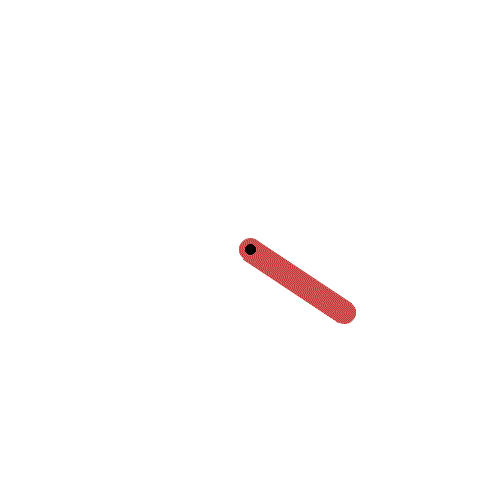

### Why Pendulum for this PlaNet Example?
As mentioned, PlaNet typically uses image inputs. However, implementing the necessary vision components (CNNs) and latent models (RSSMs) is very complex for a didactic notebook. Pendulum provides a standard **continuous state and action space** where the benefits of model-based planning are still evident. We will adapt PlaNet to work with vector states, learning a model that predicts the next state vector $\hat{s}_{t+1}$ and reward $\hat{r}_t$ directly. This allows focusing on the interplay between model learning and CEM planning. **Requires `gymnasium`.**

# Setting up the Environment

Import libraries.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import namedtuple, deque
from itertools import count
from typing import List, Tuple, Dict, Optional, Callable, Any
import copy
import time

# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Independent
from torch.distributions.kl import kl_divergence

# Import Gymnasium
try:
    import gymnasium as gym
except ImportError:
    print("Gymnasium not found. Please install using 'pip install gymnasium' or 'pip install gym[classic_control]'")
    gym = None

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

%matplotlib inline

Using device: cpu


# Creating the Continuous Environment (Gymnasium)

Instantiate Pendulum-v1.

In [2]:
# Instantiate the Pendulum environment
if gym is not None:
    try:
        env = gym.make('Pendulum-v1')
        env.reset(seed=seed)
        env.action_space.seed(seed)

        n_observations_planet = env.observation_space.shape[0]
        n_actions_planet = env.action_space.shape[0]
        action_low_planet = env.action_space.low
        action_high_planet = env.action_space.high

        print(f"Pendulum Environment:")
        print(f"State Dim: {n_observations_planet}")
        print(f"Action Dim: {n_actions_planet}")
        print(f"Action Low: {action_low_planet}")
        print(f"Action High: {action_high_planet}")
    except Exception as e:
        print(f"Error creating Gymnasium environment: {e}")
        n_observations_planet = 3
        n_actions_planet = 1
        action_low_planet = np.array([-2.0])
        action_high_planet = np.array([2.0])
        env = None
else:
    print("Gymnasium not available. Cannot create Pendulum environment.")
    n_observations_planet = 3
    n_actions_planet = 1
    action_low_planet = np.array([-2.0])
    action_high_planet = np.array([2.0])
    env = None

Pendulum Environment:
State Dim: 3
Action Dim: 1
Action Low: [-2.]
Action High: [2.]


# Implementing the PlaNet Algorithm

Define the simplified dynamics model, sequence replay buffer, CEM planner, and training functions.

### Defining the Dynamics Model (Simplified)

An MLP that takes current state $s_t$ and action $a_t$ and predicts next state $s_{t+1}$ and reward $r_t$.

In [3]:
class DynamicsModel(nn.Module):
    """ Simplified MLP-based dynamics model for PlaNet. """
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 200):
        super(DynamicsModel, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        # Simple MLP architecture
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        
        # Output heads
        self.fc_next_state = nn.Linear(hidden_dim, state_dim) # Predicts next state
        self.fc_reward = nn.Linear(hidden_dim, 1)           # Predicts reward

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Predicts the next state and reward.
        
        Parameters:
        - state (torch.Tensor): Current state tensor.
        - action (torch.Tensor): Action tensor.
        
        Returns:
        - Tuple[torch.Tensor, torch.Tensor]:
            - Predicted next state.
            - Predicted reward.
        """
        # Ensure inputs are 2D (batch_size, dim)
        if state.dim() == 1: state = state.unsqueeze(0)
        if action.dim() == 1: action = action.unsqueeze(0)
        
        x = torch.cat([state, action], dim=-1) # Concatenate state and action
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        pred_next_state = self.fc_next_state(x)
        pred_reward = self.fc_reward(x)
        
        # In a more complex model, might predict parameters of a distribution
        # e.g., mean and variance for next state/reward.
        # Here we just predict the mean directly.
        
        return pred_next_state, pred_reward

### Defining the Sequence Replay Buffer

Stores sequences of transitions, needed for training sequence-based models (even our simplified MLP benefits from sequence context implicitly).

In [4]:
# Define a transition structure for sequences
# Store observations (o), actions (a), rewards (r), next_observations (o_next), dones (d)
SeqTransition = namedtuple('SeqTransition',
                           ('observations', 'actions', 'rewards', 'next_observations', 'dones'))

class SequenceReplayBuffer:
    """ Stores sequences of transitions. """
    def __init__(self, capacity: int, sequence_length: int):
        self.capacity = capacity
        self.sequence_length = sequence_length
        self.buffer: List[Tuple[Any, ...]] = [] # Stores individual (o, a, r, o_next, d) steps
        self.position = 0

    def push(self, obs: np.ndarray, action: np.ndarray, reward: float, next_obs: np.ndarray, done: bool) -> None:
        """ Add a single step transition to the buffer. """
        # Convert to numpy for storage efficiency if needed, or keep as tensors
        transition = (obs, action, reward, next_obs, float(done)) 
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size: int) -> Optional[SeqTransition]:
        """ Sample a batch of sequences. """
        if len(self.buffer) < self.sequence_length:
            return None # Not enough data to form a sequence
            
        observations_batch = []
        actions_batch = []
        rewards_batch = []
        next_observations_batch = []
        dones_batch = []

        for _ in range(batch_size):
            # Choose a random starting point for the sequence
            start_idx = random.randint(0, len(self.buffer) - self.sequence_length)
            sequence = self.buffer[start_idx : start_idx + self.sequence_length]
            
            # Unzip the sequence
            obs_seq, act_seq, rew_seq, next_obs_seq, done_seq = zip(*sequence)
            
            observations_batch.append(np.array(obs_seq))
            actions_batch.append(np.array(act_seq))
            rewards_batch.append(np.array(rew_seq))
            next_observations_batch.append(np.array(next_obs_seq))
            dones_batch.append(np.array(done_seq))

        # Convert lists of sequences to tensors (batch_size, seq_len, feature_dim)
        obs_tensor = torch.from_numpy(np.array(observations_batch)).float().to(device)
        act_tensor = torch.from_numpy(np.array(actions_batch)).float().to(device)
        rew_tensor = torch.from_numpy(np.array(rewards_batch)).float().to(device).unsqueeze(-1) # Add feature dim
        next_obs_tensor = torch.from_numpy(np.array(next_observations_batch)).float().to(device)
        dones_tensor = torch.from_numpy(np.array(dones_batch)).float().to(device).unsqueeze(-1) # Add feature dim

        return SeqTransition(obs_tensor, act_tensor, rew_tensor, next_obs_tensor, dones_tensor)

    def __len__(self) -> int:
        return len(self.buffer)

### Implementing the CEM Planner

A function that performs CEM planning using the learned dynamics model.

In [5]:
def cem_planner(model: DynamicsModel, 
                initial_state: torch.Tensor, 
                horizon: int, 
                num_candidates: int, 
                num_elites: int, 
                num_iterations: int,
                gamma: float, 
                action_low: np.ndarray, 
                action_high: np.ndarray,
                action_dim: int) -> torch.Tensor:
    """
    Performs Cross-Entropy Method (CEM) planning using the dynamics model.

    Parameters:
    - model: The learned DynamicsModel.
    - initial_state: The state from which to start planning.
    - horizon: Planning horizon (number of steps H).
    - num_candidates: Number of action sequences to sample (J).
    - num_elites: Number of top sequences to keep (M).
    - num_iterations: Number of CEM refinement iterations.
    - gamma: Discount factor for simulated rewards.
    - action_low, action_high: Action space bounds.
    - action_dim: Dimension of the action space.

    Returns:
    - torch.Tensor: The first action of the best sequence found.
    """
    model.eval() # Set model to evaluation mode for planning

    # Initialize action distribution (Gaussian)
    # Mean initialized to zeros, std dev initialized to cover half the action range
    action_mean = torch.zeros(horizon, action_dim, device=device)
    action_std_dev = torch.ones(horizon, action_dim, device=device) * (torch.from_numpy(action_high - action_low).float().to(device) / 2.0)

    for _ in range(num_iterations):
        # Sample candidate action sequences from the current distribution
        # Shape: (num_candidates, horizon, action_dim)
        action_dist = Normal(action_mean, action_std_dev)
        candidate_actions = action_dist.sample((num_candidates,))
        
        # Clip actions to bounds
        action_low_t = torch.from_numpy(action_low).float().to(device)
        action_high_t = torch.from_numpy(action_high).float().to(device)
        candidate_actions = torch.clamp(candidate_actions, action_low_t, action_high_t)

        # Evaluate candidate sequences using the model
        total_rewards = torch.zeros(num_candidates, device=device)
        current_states = initial_state.repeat(num_candidates, 1) # Start all candidates from initial state

        with torch.no_grad(): # No gradients needed during model rollout
            for t in range(horizon):
                actions_t = candidate_actions[:, t, :] # Actions for this time step
                # Predict next state and reward using the model
                next_states, rewards = model(current_states, actions_t)
                total_rewards += (gamma ** t) * rewards.squeeze() # Accumulate discounted reward
                current_states = next_states # Move to predicted next state

        # Select elite action sequences
        _, elite_indices = torch.topk(total_rewards, num_elites) # Get indices of top M sequences
        elite_actions = candidate_actions[elite_indices]
        
        # Refit the action distribution to the elite samples
        action_mean = elite_actions.mean(dim=0)
        action_std_dev = elite_actions.std(dim=0) + 1e-6 # Add epsilon for stability

    # Return the mean of the first action in the final distribution
    best_first_action = action_mean[0]
    return best_first_action

### Model Training Function

Trains the dynamics model using sampled sequences.

In [6]:
def train_model(model: DynamicsModel, 
                model_optimizer: optim.Optimizer, 
                replay_buffer: SequenceReplayBuffer, 
                batch_size: int, 
                num_train_steps: int) -> float:
    """
    Trains the dynamics model for a number of steps.
    
    Parameters:
    - model: The DynamicsModel to train.
    - model_optimizer: The optimizer for the model.
    - replay_buffer: The sequence buffer to sample from.
    - batch_size: The number of sequences per batch.
    - num_train_steps: The number of gradient steps to perform.
    
    Returns:
    - float: The average loss over the training steps.
    """
    model.train() # Set model to training mode
    total_loss = 0.0
    steps_done = 0

    for _ in range(num_train_steps):
        # Sample a batch of sequences
        sequence_batch = replay_buffer.sample(batch_size)
        if sequence_batch is None:
            continue # Not enough data yet
            
        obs_batch, act_batch, rew_batch, next_obs_batch, dones_batch = sequence_batch
        # obs_batch shape: (batch_size, seq_len, state_dim)
        # act_batch shape: (batch_size, seq_len, action_dim)
        # rew_batch shape: (batch_size, seq_len, 1)
        # next_obs_batch shape: (batch_size, seq_len, state_dim)

        # --- Calculate Model Loss --- 
        # We need to predict next_state and reward for each step in the sequence.
        # Here, we simplify and just predict based on the first step of each sequence 
        # for demonstration. A proper implementation would iterate through the sequence
        # or use an RNN within the model.
        
        current_states = obs_batch[:, 0, :] # State at the start of sequence
        current_actions = act_batch[:, 0, :] # Action at the start of sequence
        target_next_states = next_obs_batch[:, 0, :] # True next state
        target_rewards = rew_batch[:, 0, :]      # True reward

        # Get model predictions
        pred_next_states, pred_rewards = model(current_states, current_actions)
        
        # Calculate MSE losses
        state_loss = F.mse_loss(pred_next_states, target_next_states)
        reward_loss = F.mse_loss(pred_rewards, target_rewards)
        
        # Combine losses (can add weights if needed)
        loss = state_loss + reward_loss
        
        # --- Optimize Model --- 
        model_optimizer.zero_grad()
        loss.backward()
        # Optional: Gradient clipping
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) 
        model_optimizer.step()
        
        total_loss += loss.item()
        steps_done += 1

    return total_loss / steps_done if steps_done > 0 else 0.0

# Running the PlaNet Algorithm

Set up hyperparameters, initialize components, and run the main PlaNet loop.

### Hyperparameter Setup

Define hyperparameters for PlaNet and CEM.

In [7]:
# Hyperparameters for PlaNet on Pendulum-v1
BUFFER_CAPACITY_PLANET = int(1e5)   # Buffer stores individual steps
SEQUENCE_LENGTH = 50              # Length of sequences sampled for model training
MODEL_BATCH_SIZE = 32             # Number of sequences per model training batch
MODEL_TRAIN_STEPS = 100           # Gradient steps for model per iteration
MODEL_LR = 1e-3                   # Learning rate for the dynamics model
HIDDEN_DIM_MODEL = 200            # Hidden dimension for the dynamics model

# CEM Planner Hyperparameters
PLANNING_HORIZON = 12             # How many steps ahead to plan (H)
CEM_CANDIDATES = 1000             # Candidates sampled per CEM iteration (J)
CEM_ELITES = 100                  # Elite samples to keep per CEM iteration (M)
CEM_ITERATIONS = 10               # Number of CEM refinement iterations
CEM_GAMMA = 0.99                  # Discount factor used *during planning*

# Training Loop Hyperparameters
NUM_ITERATIONS_PLANET = 50       # Number of Collect/Train iterations
STEPS_PER_ITERATION_PLANET = 100  # Environment steps collected per iteration
INITIAL_RANDOM_STEPS = 1000       # Collect initial data randomly

### Initialization

Initialize model, optimizer, and replay buffer.

In [8]:
if env is None:
    raise RuntimeError("Gymnasium environment 'Pendulum-v1' could not be created.")

# Initialize Dynamics Model
dynamics_model = DynamicsModel(n_observations_planet, 
                               n_actions_planet, 
                               HIDDEN_DIM_MODEL).to(device)

# Initialize Model Optimizer
model_optimizer = optim.Adam(dynamics_model.parameters(), lr=MODEL_LR)

# Initialize Replay Buffer
replay_buffer = SequenceReplayBuffer(BUFFER_CAPACITY_PLANET, SEQUENCE_LENGTH)

# Lists for plotting
planet_iteration_rewards = []
planet_iteration_model_losses = []

# --- Collect Initial Random Data --- 
print(f"Collecting {INITIAL_RANDOM_STEPS} initial random steps...")
obs_np, _ = env.reset()
for _ in range(INITIAL_RANDOM_STEPS):
    action_np = env.action_space.sample()
    next_obs_np, reward, terminated, truncated, _ = env.step(action_np)
    done = terminated or truncated
    replay_buffer.push(obs_np, action_np, reward, next_obs_np, done)
    obs_np = next_obs_np
    if done:
        obs_np, _ = env.reset()
print("Initial data collection complete.")

Initial data collection complete.


### Training Loop

The PlaNet loop: Collect data using CEM planning, then train the world model.

In [9]:
print("Starting PlaNet Training on Pendulum-v1...")

# --- PlaNet Training Loop ---
total_steps_planet = 0
current_state_np, _ = env.reset()
current_state = torch.from_numpy(current_state_np).float().to(device)

for iteration in range(1, NUM_ITERATIONS_PLANET + 1):
    # --- 1. Collect Data using Planner --- 
    iteration_rewards_list = []
    current_episode_reward = 0.0
    steps_this_iter = 0
    
    while steps_this_iter < STEPS_PER_ITERATION_PLANET:
        # Plan action using CEM
        action_tensor = cem_planner(
            dynamics_model,
            current_state,
            horizon=PLANNING_HORIZON,
            num_candidates=CEM_CANDIDATES,
            num_elites=CEM_ELITES,
            num_iterations=CEM_ITERATIONS,
            gamma=CEM_GAMMA, # Use planning discount
            action_low=action_low_planet,
            action_high=action_high_planet,
            action_dim=n_actions_planet
        )
        action_np = action_tensor.detach().cpu().numpy()
        # Clip just in case CEM produces values slightly out of bounds
        action_np_clipped = np.clip(action_np, action_low_planet, action_high_planet)

        # Interact with environment
        next_state_np, reward, terminated, truncated, _ = env.step(action_np_clipped)
        done = terminated or truncated
        
        # Store experience
        replay_buffer.push(current_state_np, action_np_clipped, reward, next_state_np, done)
        
        current_state_np = next_state_np
        current_state = torch.from_numpy(current_state_np).float().to(device)
        current_episode_reward += reward
        total_steps_planet += 1
        steps_this_iter += 1
        
        if done:
            iteration_rewards_list.append(current_episode_reward)
            current_state_np, _ = env.reset()
            current_state = torch.from_numpy(current_state_np).float().to(device)
            current_episode_reward = 0.0
            # Check if iteration step limit reached even if episode ended early
            if steps_this_iter >= STEPS_PER_ITERATION_PLANET:
                break
                
    # --- 2. Train World Model --- 
    avg_model_loss = train_model(dynamics_model, model_optimizer, replay_buffer,
                                 MODEL_BATCH_SIZE, MODEL_TRAIN_STEPS)

    # --- Logging --- 
    avg_iter_reward = np.mean(iteration_rewards_list) if iteration_rewards_list else np.nan
    planet_iteration_rewards.append(avg_iter_reward)
    planet_iteration_model_losses.append(avg_model_loss)
    
    if iteration % 10 == 0:
        print(f"Iter {iteration}/{NUM_ITERATIONS_PLANET} | Steps: {total_steps_planet} | Avg Ep Reward: {avg_iter_reward:.2f} | Model Loss: {avg_model_loss:.6f}")

print("Pendulum-v1 Training Finished (PlaNet).")

Starting PlaNet Training on Pendulum-v1...
Iter 10/50 | Steps: 1000 | Avg Ep Reward: -492.32 | Model Loss: 0.040212
Iter 20/50 | Steps: 2000 | Avg Ep Reward: -267.97 | Model Loss: 0.006726
Iter 30/50 | Steps: 3000 | Avg Ep Reward: -519.70 | Model Loss: 0.004455
Iter 40/50 | Steps: 4000 | Avg Ep Reward: -151.99 | Model Loss: 0.003335
Iter 50/50 | Steps: 5000 | Avg Ep Reward: -0.64 | Model Loss: 0.002298
Pendulum-v1 Training Finished (PlaNet).


# Visualizing the Learning Process

Plot average episode rewards per iteration and the model training loss.

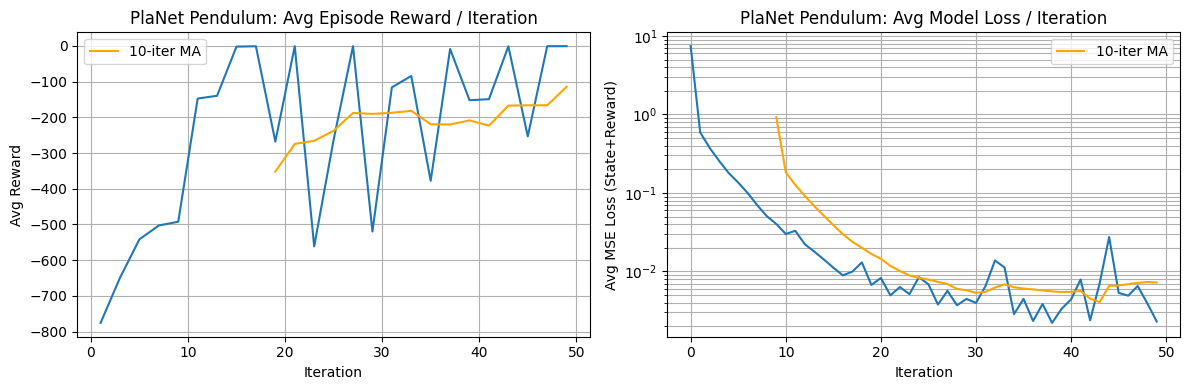

In [10]:
# Plotting results for PlaNet on Pendulum-v1
plt.figure(figsize=(12, 4))

# Average Episode Rewards per Iteration
plt.subplot(1, 2, 1)
valid_rewards_planet = [r for r in planet_iteration_rewards if not np.isnan(r)]
valid_indices_planet = [i for i, r in enumerate(planet_iteration_rewards) if not np.isnan(r)]
plt.plot(valid_indices_planet, valid_rewards_planet)
plt.title('PlaNet Pendulum: Avg Episode Reward / Iteration')
plt.xlabel('Iteration')
plt.ylabel('Avg Reward')
plt.grid(True)
if len(valid_rewards_planet) >= 10:
    rewards_ma_planet = np.convolve(valid_rewards_planet, np.ones(10)/10, mode='valid')
    plt.plot(valid_indices_planet[9:], rewards_ma_planet, label='10-iter MA', color='orange')
    plt.legend()

# Model Loss per Iteration
plt.subplot(1, 2, 2)
plt.plot(planet_iteration_model_losses)
plt.title('PlaNet Pendulum: Avg Model Loss / Iteration')
plt.xlabel('Iteration')
plt.ylabel('Avg MSE Loss (State+Reward)')
plt.yscale('log') # Loss often decreases significantly, log scale helps
plt.grid(True, which='both')
if len(planet_iteration_model_losses) >= 10:
    mloss_ma_planet = np.convolve(planet_iteration_model_losses, np.ones(10)/10, mode='valid')
    plt.plot(np.arange(len(mloss_ma_planet)) + 9, mloss_ma_planet, label='10-iter MA', color='orange')
    plt.legend()

plt.tight_layout()
plt.show()

**Analysis of PlaNet Learning Curves (Pendulum):**

1.  **Avg Episode Reward / Iteration (Left Plot):**
    *   **Observation:** This plot shows an extremely rapid initial phase of learning. Starting from very poor performance (~-800), the average reward shoots up dramatically within the first 15-20 iterations, reaching values close to the optimal range (approaching 0). Following this steep ascent, the reward exhibits significant instability, with large oscillations between near-optimal performance and much lower rewards (-400 or worse). The 10-iteration moving average (orange line) captures the overall high level achieved after the initial learning but smooths over these pronounced peaks and troughs.
    *   **Interpretation:** The rapid initial improvement highlights the potential sample efficiency of PlaNet. By learning a dynamics model, it can quickly leverage simulated experience ("planning") to find decent policies with relatively few real environment interactions. The subsequent volatility, however, is crucial. It suggests that while the learned model is good enough for initial progress, it likely contains inaccuracies. The planner (CEM in PlaNet) might find action sequences that yield high rewards *according to the imperfect model*, but these plans don't perfectly translate to the real environment, leading to performance drops. This discrepancy between model-based plans and real-world outcomes causes the observed oscillations.

2.  **Avg Model Loss / Iteration (Right Plot):**
    *   **Observation:** This plot shows the average Mean Squared Error (MSE) loss for the world model's predictions (next state and reward) on a logarithmic scale. The loss decreases very rapidly by several orders of magnitude during the first ~15 iterations, corresponding precisely with the period of fastest reward improvement. After this initial drop, the loss stabilizes at a low average value (around 0.01-0.02), with some minor fluctuations later in training.
    *   **Interpretation:** The sharp initial decrease confirms that the world model component of PlaNet is learning effectively and quickly capturing the short-term dynamics of the Pendulum environment from the collected experience. This ability to quickly build a reasonably predictive model is what enables the fast initial policy improvement seen in the reward plot. The stabilization indicates the model has reached a certain level of accuracy, likely limited by the complexity of the dynamics, the model capacity, and the quality/diversity of the collected data. Even a low average loss doesn't guarantee perfect long-term predictions, which is essential for the multi-step planning phase.

**Overall Conclusion:**
PlaNet demonstrates impressive initial sample efficiency on the Pendulum task, rapidly improving rewards by learning a predictive world model and planning using it. The model loss converges quickly to low values, indicating good short-term prediction capabilities. However, the pronounced volatility in rewards after the initial learning phase suggests that inaccuracies in the learned model are amplified by the multi-step planning process (CEM). This leads to plans that are optimal within the learned model but suboptimal or unstable when executed in the true environment, highlighting the challenge of model bias in model-based reinforcement learning, especially for continuous control tasks requiring precise long-horizon predictions.

# Analyzing the Learned Policy (Testing)

Visualize the performance of the PlaNet agent by running it in the environment, using the planner at each step.

In [11]:
def test_planet_agent(model: DynamicsModel, 
                      env_instance: gym.Env, 
                      num_episodes: int = 5, 
                      render: bool = False, 
                      seed_offset: int = 3000, 
                      cem_params: dict = {}) -> None:
    """
    Tests the trained PlaNet agent using CEM planning at each step.
    """
    if env_instance is None:
        print("Environment not available for testing.")
        return
        
    model.eval() # Set model to evaluation mode
    
    # Get CEM params or use defaults
    horizon = cem_params.get('horizon', PLANNING_HORIZON)
    candidates = cem_params.get('candidates', CEM_CANDIDATES)
    elites = cem_params.get('elites', CEM_ELITES)
    iterations = cem_params.get('iterations', CEM_ITERATIONS)
    gamma = cem_params.get('gamma', CEM_GAMMA)
    action_dim = env_instance.action_space.shape[0]
    action_low = env_instance.action_space.low
    action_high = env_instance.action_space.high

    print(f"\n--- Testing PlaNet Agent ({num_episodes} episodes) ---")
    all_rewards = []
    for i in range(num_episodes):
        state_np, info = env_instance.reset(seed=seed + seed_offset + i)
        state = torch.from_numpy(state_np).float().to(device)
        episode_reward = 0
        done = False
        t = 0
        while not done:
            if render:
                try:
                    env_instance.render()
                    time.sleep(0.01)
                except Exception as e:
                    print(f"Rendering failed: {e}. Disabling render.")
                    render = False
            
            # Plan action using CEM
            action_tensor = cem_planner(
                model, state, horizon, candidates, elites, iterations, gamma,
                action_low, action_high, action_dim
            )
            action_np = action_tensor.detach().cpu().numpy()
            action_np_clipped = np.clip(action_np, action_low, action_high)
            
            # Step environment
            next_state_np, reward, terminated, truncated, _ = env_instance.step(action_np_clipped)
            done = terminated or truncated
            state = torch.from_numpy(next_state_np).float().to(device)
            episode_reward += reward
            t += 1
        
        print(f"Test Episode {i+1}: Reward = {episode_reward:.2f}, Length = {t}")
        all_rewards.append(episode_reward)
        if render:
             env_instance.close()

    print(f"--- Testing Complete. Average Reward: {np.mean(all_rewards):.2f} ---")

# Run test episodes (ensure env is still available)
# Pass CEM parameters used during training (or potentially refined ones)
test_cem_params = {
    'horizon': PLANNING_HORIZON,
    'candidates': CEM_CANDIDATES,
    'elites': CEM_ELITES,
    'iterations': CEM_ITERATIONS,
    'gamma': CEM_GAMMA
}
test_planet_agent(dynamics_model, env, num_episodes=3, render=False, cem_params=test_cem_params)


--- Testing PlaNet Agent (3 episodes) ---
Test Episode 1: Reward = -1765.54, Length = 200
Test Episode 2: Reward = -4.07, Length = 200
Test Episode 3: Reward = -392.67, Length = 200
--- Testing Complete. Average Reward: -720.76 ---


## Common Challenges and Extensions of PlaNet

**Challenge: Model Accuracy vs. Complexity**
*   **Problem:** Learning an accurate world model, especially from high-dimensional data like images or for complex dynamics, is inherently difficult. Simple models might be inaccurate, while complex models (like full RSSMs) are hard to train and computationally expensive.
*   **Solutions**:
    *   **Better Model Architectures:** Using more sophisticated sequence models (RSSM, Transformers) designed for dynamics modeling.
    *   **Probabilistic Models:** Predicting distributions over next states/rewards captures uncertainty.
    *   **Careful Regularization:** Techniques like KL regularization in variational models help structure the latent space.
    *   **Focus on Relevant Information:** Design models to predict only what's necessary for planning.

**Challenge: Compounding Model Errors**
*   **Problem:** During planning (simulating over horizon $H$), small prediction errors at each step can accumulate, leading to inaccurate long-term predictions and potentially poor plans.
*   **Solutions**:
    *   **Shorter Planning Horizon ($H$):** Reduces the potential for error accumulation but might lead to myopic behavior.
    *   **More Accurate Models:** Improving the single-step prediction accuracy.
    *   **Model Ensemble:** Train multiple models and average their predictions during planning.
    * **Re-planning:** Frequently re-plan from the current *real* state to correct for deviations.

**Challenge: Planning Cost**
*   **Problem:** Performing iterative optimization like CEM at every time step can be computationally expensive, limiting real-time application.
   **Solutions**:
    *   **Efficient Planners:** Investigate faster planning algorithms (e.g., gradient-based trajectory optimization if the model is differentiable, or optimized CEM implementations).
    *   **Reduce CEM Parameters:** Decrease candidates ($J$), elites ($M$), or iterations, trading off planning quality for speed.
    *   **Plan Less Frequently:** Execute multiple actions from a single plan before re-planning.
    *   **Amortized Planning (Policy Learning):** Train a separate policy network (actor) using the planner's outputs as targets (as done in later algorithms like Dreamer), effectively distilling the planning computation into a fast policy network.

**Challenge: Discrepancy between Model and Reality (Sim-to-Real Gap)**
*   **Problem:** Even a well-trained model is an approximation. Policies optimized entirely within the model might not transfer perfectly to the real world.
*   **Solutions**:
    *   **Continuous Model Updates:** Keep training the model with new real data.
    *   **Robust Planning:** Use techniques that account for model uncertainty during planning.
    *   **System Identification:** Techniques to explicitly improve model accuracy in relevant parts of the state space.

**Extensions (Dreamer Family):**
- **DreamerV1/V2/V3:** Successors to PlaNet that build upon the core ideas. They typically use more advanced RSSMs, learn policy and value functions *within the latent space* using imagined trajectories, and often achieve even higher sample efficiency and performance.

## Conclusion

PlaNet represents a powerful paradigm in model-based reinforcement learning, demonstrating the potential of learning world models, particularly in latent space, and leveraging them for planning. By decoupling model learning from policy execution, it aims for high sample efficiency, making it suitable for complex tasks, especially those with high-dimensional observations like images.

The core loop involves collecting experience, training the latent dynamics model (predicting states and rewards), and using a planner like CEM to find optimal action sequences based on the model's simulations. While facing challenges related to model accuracy, compounding errors, and planning cost, PlaNet's approach of planning in a learned latent space has been highly influential, paving the way for subsequent state-of-the-art algorithms like the Dreamer series.